# A/B Test of a Game

In this A/B test analysis, we will examine a small variation in a mobile app game. In the game, Cookie Cats, users are split into a control/test group where the control group see a gate at level 30, or a test group where they don't see the gate until level 40. The main metric of this analysis will be rounds played for 14 days, which be used as a proxy for retentions (more rounds = better retentions).


Data Source: https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing/data

### Data Schema:
* Userid: A unique number that identifies each player.
* version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
* sum_gamerounds: The number of game rounds played by the player during the first 14 days after install.
* retention_1: Did the player come back and play 1 day after installing?
* retention_7: Did the player come back and play 7 days after installing?

In [6]:
# Import libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os


import statsmodels.api as sm
from scipy.stats import levene, ttest_ind


In [4]:
# Set project paths
repo = os.path.abspath('')
data_file = os.path.join(repo, 'Data', 'cookie_cats.csv')

In [5]:
# Load Dataset
source_df = pd.read_csv(data_file)

In [7]:
# Let's now do some high-level analysis of the data/metadata to spot any additional cleaning or null handling
rows_num, cols_num = source_df.shape
sum_nas = source_df.isna().any().sum()

print(f'Source data has {rows_num} rows and {cols_num} columns')
print(f'Over all the columns there are {sum_nas} NAs')
print('\n')
source_df.info()
source_df.groupby('version')['sum_gamerounds'].describe()

Source data has 90189 rows and 5 columns
Over all the columns there are 0 NAs


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


Since most columns are boolean, we can only really see the descriptive statistics of the sum of gamerounds -- which is still valuable! After grouping by the Control/Test variable, what can be gleamed from it? 

Well, we can see that both versions have comparables means, but very different standard deviations. Likely, driven by the fact that the gate_30 has an enormous outlier in the max value for sum_gamerounds. Potentially an issue in the data that we may have to exclude, but let's dig into it a bit deeper.

In [8]:
# Let's first clean up our data so it's more familiar/self-explanatory.
df_clean = (
    source_df
    .assign(
        CONTROL_TEST = lambda df: np.where(df['version'] == 'gate_30', 'Control', 'Treatment') 
    )
    .drop(columns='version')
    .rename(columns={
        'userid': 'USER_ID',
        'sum_gamerounds': 'SUM_ROUNDS_14D',
        'retention_1': 'RETURNED_AFTER_1D',
        'retention_7': 'RETURNED_AFTER_7D'
    })
    .assign(
        DROPPED_OFF = lambda df: np.where( (df['RETURNED_AFTER_1D'] == True) & (df['RETURNED_AFTER_7D'] == False), True, False)
    )
    # re-sort columns
    .filter(items=['USER_ID', 'CONTROL_TEST', 'RETURNED_AFTER_1D', 'RETURNED_AFTER_7D', 'DROPPED_OFF', 'SUM_ROUNDS_14D'])
)
df_clean.sample(6, random_state=5)

,USER_ID,CONTROL_TEST,RETURNED_AFTER_1D,RETURNED_AFTER_7D,DROPPED_OFF,SUM_ROUNDS_14D
66494,7361631,Treatment,False,False,False,19
69787,7735382,Treatment,True,False,True,33
29479,3277533,Treatment,False,False,False,13
11642,1287216,Control,True,False,True,28
83513,9253662,Control,False,False,False,2
46331,5131990,Treatment,False,False,False,2


Let's dig into that outlier now.

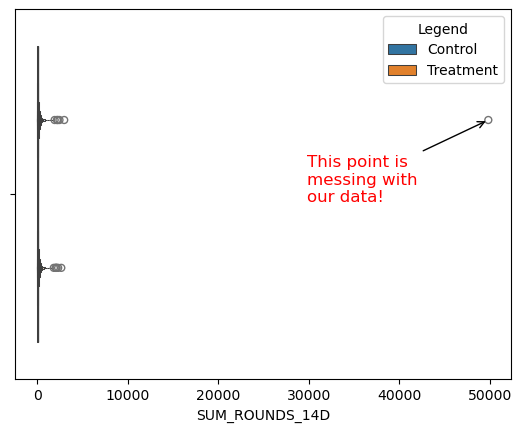

In [50]:
max_val = df_clean['SUM_ROUNDS_14D'].max()
ax = sns.boxenplot(data=df_clean, x='SUM_ROUNDS_14D', hue='CONTROL_TEST')
plt.annotate(
    'This point is\nmessing with\nour data!',
    xy=(max_val, -.2),  
    xytext=(max_val-20_000, .02),  
    arrowprops=dict(facecolor='red', arrowstyle='->'),
    fontsize=12,
    color='red'
)
ax.legend(title='Legend')
plt.show()

Given that it's ONE point only, and we have ~44K points per group, I feel more than comfortable dismissing that one point because:
* It's likely just an issue/bug/error (I doubt the game even has that many rounds?)
* If it's not an issue, that single use does not represent the overall distribution.

While we're at it, we will also exclude any 0 observation rounds total. Not only do 0-round observations potentially change our results, we also cannot measure any sort of effect since they chose to not participate after downloading the application. This ended up being 3994 players that did not play any rounds.

In [63]:
# Find and drop Index of outlier
# Many ways to do this, but I'm choosing to do it with index
df_manipulated = (
    df_clean[ ~(df_clean['SUM_ROUNDS_14D'] == df_clean['SUM_ROUNDS_14D'].max())
             & ~(df_clean['SUM_ROUNDS_14D'] == 0)
             ]
    .reset_index(drop=True)
)

max_val = df_manipulated['SUM_ROUNDS_14D'].max()
min_val = df_manipulated['SUM_ROUNDS_14D'].min()

print(f'New min: {min_val} round.\nNew Max: {max_val} rounds.')

New min: 1 round.
New Max: 2961 rounds.


We've now removed the outlier and 0-round totals. Our new max value of rounds for 14 days is `2,961`, and minimum is `1` round.

<Axes: xlabel='SUM_ROUNDS_14D'>

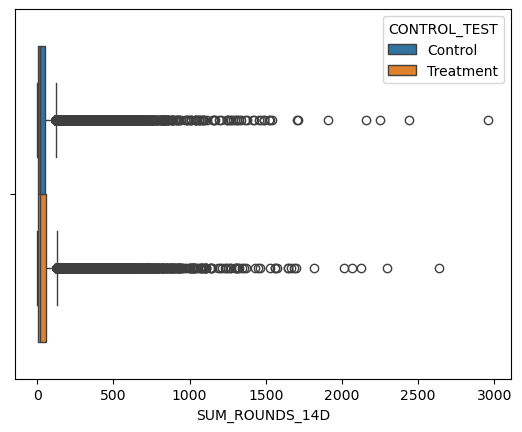

In [64]:
# Let's see the new boxplots
sns.boxplot(data=df_manipulated, x='SUM_ROUNDS_14D', hue='CONTROL_TEST')

Okay, there are still a healthy chunk of outliers, but now they seem representative of the dataset, instead of just a flat out error. One approach to this is leveraging bootstrapping (essentially applying Central Limit Theorem).

Let's now look at retention differences between each version (control or test) of the game.

## Retention Differences (1 Day)

In [70]:
df_manipulated.groupby('CONTROL_TEST', as_index=False)['RETURNED_AFTER_1D'].mean()

# 0.462171 - 0.467541 #0.05

,CONTROL_TEST,RETURNED_AFTER_1D
0,Control,0.467541
1,Treatment,0.462171


Not a very strong difference in retention on 1 Day. Treatment saw a 0.005 percentage point less retention than control. The minute difference is likely due to the fact that 1 Day is simply not enough for any players to really get to the gate 30/40.

## Retention Differences (7 Day)

In [68]:
df_manipulated.groupby('CONTROL_TEST', as_index=False)['RETURNED_AFTER_7D'].mean()

,CONTROL_TEST,RETURNED_AFTER_7D
0,Control,0.198424
1,Treatment,0.190321


On the 7-day, we now see a bigger difference between Control and Treatment. Again, suggesting that treatment had a negative impact (though slight) on retention. In this case, it was 0.008 percentage points reduction in Treatment vs Control.

Since our data is highly skewed, instead of manually removing any values from the dataset which could delete valuable insight, instead we will leverage Bootstrapping to approximate our data to a normal distribution. This will allow us to leverage various statistical tests like T-Tests to find statistical differences between the groups (or not find any!). 

# Bootstrapping

As mentioned previously, our main concern is going to be the total 14 rounds played. Ideally, if we had more data, we could measure the drop-off of players AT the level 30 for the control, and the drop-off of players AT level 40 for the treatment to see if the drop is much different between the two groups.

In [109]:
control_data = df_manipulated[df_manipulated['CONTROL_TEST'] == 'Control']['SUM_ROUNDS_14D']
treatment_data = df_manipulated[df_manipulated['CONTROL_TEST'] == 'Treatment']['SUM_ROUNDS_14D']


confidence_level = 0.95
num_bootstrapped_samples = 10_000

control_bootstrapped_means = np.random.choice(control_data, size=(num_bootstrapped_samples, len(control_data)), replace=True).mean(axis=1)
treatment_bootstrapped_means = np.random.choice(treatment_data, size=(num_bootstrapped_samples, len(treatment_data)), replace=True).mean(axis=1)

control_lower_bound = np.percentile(control_bootstrapped_means, (1 - confidence_level) / 2 * 100)
control_upper_bound = np.percentile(control_bootstrapped_means, (1 + confidence_level) / 2 * 100)


treatment_lower_bound = np.percentile(treatment_bootstrapped_means, (1 - confidence_level) / 2 * 100)
treatment_upper_bound = np.percentile(treatment_bootstrapped_means, (1 + confidence_level) / 2 * 100)


print(f"Control 95% Confidence Interval {(control_lower_bound, control_upper_bound)}")
print(f"Treatment 95% Confidence Interval {(treatment_lower_bound, treatment_upper_bound)}")

Control 95% Confidence Interval (52.700236775641926, 54.64729608063234)
Treatment 95% Confidence Interval (52.762316379627926, 54.70124907902007)


So, it's a very slight difference, but the uplift in overall rounds played after bootstrapping is seen in the treatment group over the control group. I.e., it seems that, on average, the treatment group DID play more rounds than the control group. But is it practically different, or just pure chance? 

Let's test that next after plotting some distributions.

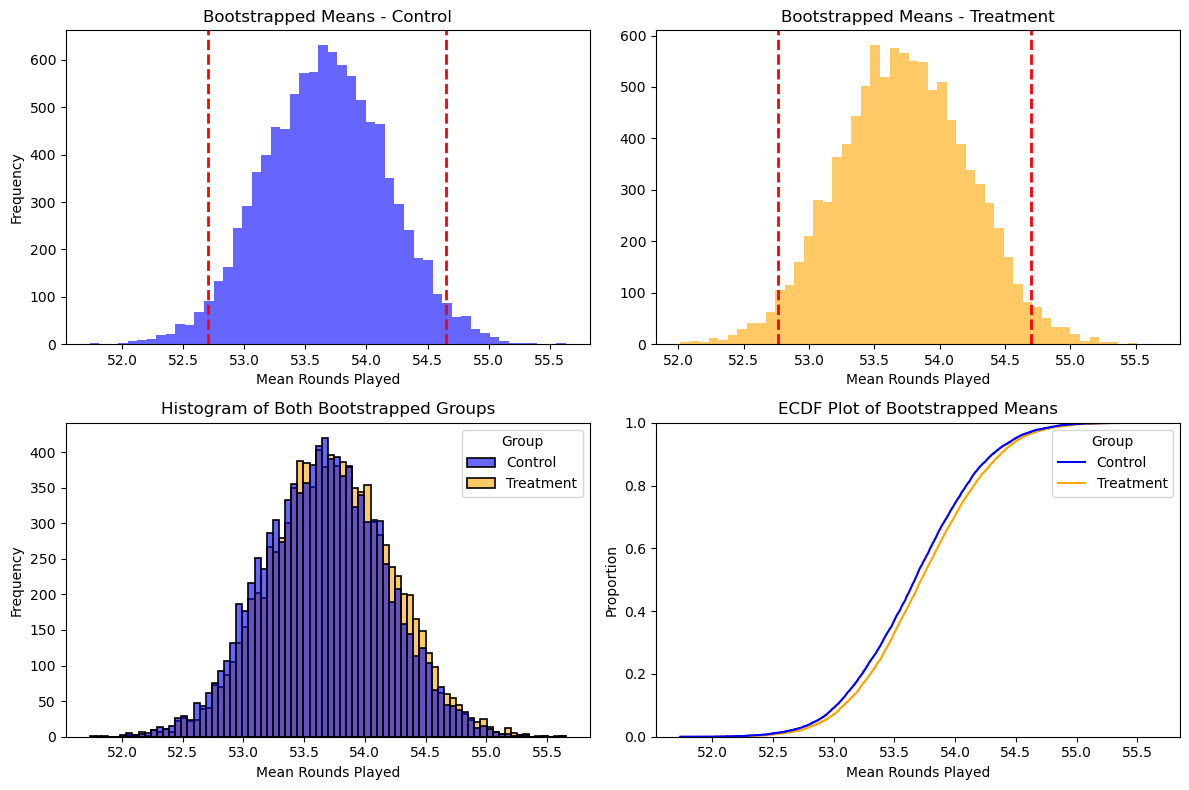

In [110]:
bootstrapped_df = pd.DataFrame({
    'Group': ['Control'] * len(control_bootstrapped_means) + ['Treatment'] * len(treatment_bootstrapped_means),
    'Bootstrapped Mean': np.concatenate([control_bootstrapped_means, treatment_bootstrapped_means])
})


fig, axes = plt.subplots(2, 2, figsize=(12, 8))

#Control 
axes[0,0].hist(control_bootstrapped_means, bins=50, color='blue', alpha=0.6)
axes[0,0].axvline(control_lower_bound, color='red', linestyle='dashed', linewidth=2, label='95% CI Lower')
axes[0,0].axvline(control_upper_bound, color='red', linestyle='dashed', linewidth=2, label='95% CI Upper')
axes[0,0].set_title("Bootstrapped Means - Control")
axes[0,0].set_xlabel("Mean Rounds Played")
axes[0,0].set_ylabel("Frequency")



# Treatment 
axes[0,1].hist(treatment_bootstrapped_means, bins=50, color='orange', alpha=0.6)
axes[0,1].axvline(treatment_lower_bound, color='red', linestyle='dashed', linewidth=2, label='95% CI Lower')
axes[0,1].axvline(treatment_upper_bound, color='red', linestyle='dashed', linewidth=2, label='95% CI Upper')
axes[0,1].set_title("Bootstrapped Means - Treatment")
axes[0,1].set_xlabel("Mean Rounds Played")


#let's superimoose both distributions
sns.histplot( data=bootstrapped_df, x='Bootstrapped Mean', hue='Group', 
                alpha=0.6, edgecolor='black', linewidth=1.2, 
                ax=axes[1,0], palette={'Control':'blue', 'Treatment':'orange'}
)
axes[1,0].set_title('Histogram of Both Bootstrapped Groups')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_xlabel("Mean Rounds Played")

#ECDF of both dists.
sns.ecdfplot(data=bootstrapped_df, x='Bootstrapped Mean', hue='Group', 
                ax=axes[1,1], palette={'Control':'blue', 'Treatment':'orange'}
)
axes[1,1].set_title('ECDF Plot of Bootstrapped Means')
axes[1,1].set_ylabel('Proportion')
axes[1,1].set_xlabel("Mean Rounds Played")


# Adjust layout
plt.tight_layout()
plt.show()

Since we're now working with bootstrapped values, continuing with the Confidence Intervals is likely the best case. So, with that, we can compare the bootstrapped means, find the differences, and then get the 95% confidence bounds of the differences and determine if it's statistically signifcant that way or not.

Reasons we are not running a t-test is simply due to the sample size. When running at such high sample size like what we've got, even infinitesimally small differences will be picked up as statistically significant. Using C.I., instead, looks at the practicality of the differences.

In [ ]:
bootstrapped_diffs = treatment_bootstrapped_means - control_bootstrapped_means

ci_lower, ci_upper = np.percentile(bootstrapped_diffs, [2.5, 97.5])

print(f"95% CI of Difference: ({ci_lower:.3f}, {ci_upper:.3f})")

if ci_lower > 0 or ci_upper < 0:
    print("The difference is statistically significant.")
else:
    print("No significant difference detected.")


95% CI of Difference: (-1.316, 1.458)
No significant difference detected.


# Conclusion

Even though we do see a difference in the bootstrapped values, that difference is simply overshadowed by the fact that it's such a minute difference to not really matter. Meaning, there was no additional attrition from moving the gate from level 30 to level 40. However, there was no increase in engagement because of it, as well.

Additionally, there is even (seemingly) a strong difference when filtering to players that did return after 7 days, but showing that data and analyzing would simply cause further confusion and conflict in the overall analysis, and would be taken out of context when the final answer remains unchanged -- which is there was no real effect (negative or positive) on the playerbase from moving the gates.

So, if there is another circumstance for which we want to move the gate to level 40 from 30, there is enough reason to believe that it would not affect the playerbase significantly. However, if the idea was to change the gate to increase engagement for players to feel "accomplished", that level of significance is not substantiated by the data.